# Raster subsetting
The size of a satellite image depends on the number of bands, the number of pixels, and the digitization of the pixel values. In any case even a single band usually takes some tens of megabytes and might be even more than 1 GB. Even when we are interested only in a subset of an image we have to download the full image and extract a subset from it. In the near future we might have a solution like the [Cloud Optimized GeoTIFF](https://www.cogeo.org/) but till the technology will be adopted by the USGS or Copernicus, we have to download the full images. In this notebook we want to extract a patch from an image and save it into a new GeoTIFF file. We begin with an image that contains only one band then we will see how to achieve the same result with an RGB image.

In [3]:
import os
import numpy as np
import math
from osgeo import gdal, osr, ogr
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
print("NumPy version: %s"%np.__version__)
print("GDAL version: %s"%gdal.__version__)

NumPy version: 1.23.1
GDAL version: 3.5.1


## Landsat 9 imagery
Let's download an image from the [Landsat 9](https://www.usgs.gov/landsat-missions/landsat-9) collection, the band 2 (0.450 - 0.51 µm) of a scene over Southern Italy to begin with

In [4]:
path = 'data/raster/Landsat/Italy/'
band2_fn = os.path.join(path, 'LC09_L1TP_190031_20230214_20230310_02_T1_B2.TIF')

Image format: TIFF
Shape (rows, cols): (7841, 7951)
Mode: I;16


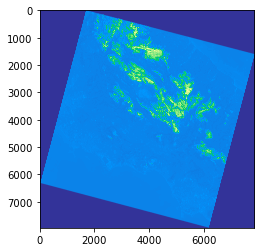

In [19]:
im_band2 = Image.open(band2_fn)
print('Image format: {}\nShape (rows, cols): {}\nMode: {}'.format(im_band2.format, im_band2.size, im_band2.mode))
plt.imshow(im_band2, cmap='terrain')

In [ ]:
band2_ds = gdal.Open(band2_fn)
rows = band2_ds.RasterXSize
cols = band2_ds.RasterYSize
print('Rows: {0}\nColumns: {1}'.format(rows, cols))

We need to know which coordinate reference system (CRS) is used in the image, the coordinates of the origin of the Landsat image, the pixel size (resolution), and the lenght of the area of interest in the horizontal and vertical directions. We will use the same CRS also for the subset image. We can see that the CRS is the projected Universal Transverse Mercator (UTM) [EPSG:32633](https://epsg.io/32633)

In [5]:
band2_ds.GetProjection()

'PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]'

In [6]:
x_origin, x_pixel_resolution, row_rotation, y_origin, column_rotation, y_pixel_resolution = band2_ds.GetGeoTransform()
print('x origin: {} m.\ny origin: {} m.\nx pixel res.: {} m.\ny pixel res: {} m.'.format(x_origin, 
                                                                                         y_origin, 
                                                                                         x_pixel_resolution, 
                                                                                         y_pixel_resolution))

x origin: 264885.0 m.
y origin: 4742715.0 m.
x pixel res.: 30.0 m.
y pixel res: -30.0 m.


In [7]:
band2_ds.GetGeoTransform()

(264885.0, 30.0, 0.0, 4742715.0, 0.0, -30.0)

The image cover an area of 235 x 238 $Km^2$ but our area of interest is smaller 

In [8]:
x_size = rows * x_pixel_resolution
y_size = cols * x_pixel_resolution
print('X size: {:0.1f} Km\nY size: {:0.1f} Km'.format(x_size / 1000, y_size / 1000))

X size: 235.2 Km
Y size: 238.5 Km


The subset image covers a rectangular polygon that is translated from the origin of the Landsat image. In order to create the subset image we need to compute the coordinates of its origin and define its lenght in the horizontal and vertical directions. The coordinates of the origin of the subset image are referred to the origin of the coordinate reference system of the Landsat image. For example, we want to translate the origin $(x_s, y_s)$ of the subset image 105 Km to the east and 165 Km to the south with respect to the origin $(x_o, y_o)$ of the Landsat image.

$$x_s = x_o + x_t$$
$$y_s = y_o + y_t$$

We use the same unit (meter) of the CRS of the Landsat image.

In [10]:
x_t = 105000 # shift of the subset origin from the image origin in meters in the horizontal direction
y_t = -165000 # shift of the subset origin from the image origin in meters in the vertical direction
delta_x = 20000 # length in meters of the subset in the horizontal direction
delta_y = -20000 # length in meters of the subset in the vertical direction
x_s = x_origin + x_t # x coordinate of the subset origin with respect to the CRS
y_s = y_origin + y_t # y coordinate of the subset origin with respect to the CRS
print('Coordinates of the origin of the subset image: x = {} m, y ={} m\n'.format(x_s, y_s))

Coordinates of the origin of the subset image: x = 369885.0 m, y =4577715.0 m



In order to extract the subset from the Landsat image we have to compute the indices (row and column) of the subset origin and the number of columns (x direction), and the number of rows (y direction) of the subset image.

In [11]:
s_col = int(x_t / x_pixel_resolution)
s_row = int(y_t / y_pixel_resolution)
s_col, s_row

(3500, 5500)

In [12]:
sub_cols = round(delta_x / x_pixel_resolution)
sub_rows = round(delta_y / y_pixel_resolution)
sub_cols, sub_rows  

(667, 667)

Now we can copy the data from the Landsat image to the subset image

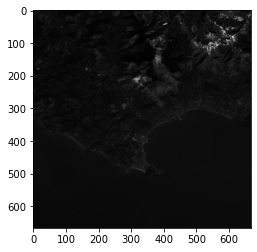

In [13]:
patch_data = np.empty((sub_cols, sub_rows), dtype=float)
band2_ds.ReadAsArray(s_col, s_row, sub_cols, sub_rows, buf_obj=patch_data)
plt.imshow(patch_data, cmap='gray')

We create a GeoTIFF file to store the subset image.

In [14]:
patch_fn = os.path.join(path, 'patch.tif')
num_bands = 1
gtiff_driver = gdal.GetDriverByName('GTiff')
patch_ds = gtiff_driver.Create(patch_fn, sub_cols, sub_rows, num_bands, band2_ds.GetRasterBand(1).DataType)
patch_ds.SetProjection(band2_ds.GetProjection())
patch_ds.SetGeoTransform([x_s, x_pixel_resolution, 0.0, y_s, 0.0, y_pixel_resolution])
patch_band = patch_ds.GetRasterBand(1)
patch_band.WriteArray(patch_data)
patch_ds.FlushCache()

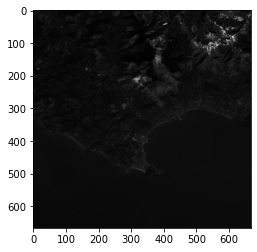

In [15]:
patch_im = Image.open(patch_fn)
plt.imshow(patch_im, cmap='gray')

In [16]:
del patch_ds

In [17]:
del band2_ds

We can define a function to implement the process

In [18]:
def subset_raster(path_input_image, x_t, y_t, delta_x, delta_y, path_subset):
    '''
    Returns a subset of a raster image in the GeoTiff format.
    '''
    band_ds = gdal.Open(path_input_image)
    gt = band_ds.GetGeoTransform()
    x_0 = gt[0]
    y_0 = gt[3]
    x_s = x_0 + x_t
    y_s = y_0 + y_t
    x_res = gt[1]
    y_res = gt[5]
    s_col = int(x_t / x_res)
    s_row = int(y_t / y_res)
    sub_cols = round(delta_x / x_res)
    sub_rows = round(delta_y / abs(y_res))
    patch_data = np.empty((sub_cols, sub_rows), dtype=float)
    band_ds.ReadAsArray(s_col, s_row, sub_cols, sub_rows, buf_obj=patch_data)
    num_bands = 1
    gtiff_driver = gdal.GetDriverByName('GTiff')
    patch_ds = gtiff_driver.Create(path_subset, sub_cols, sub_rows, num_bands, band_ds.GetRasterBand(1).DataType)
    patch_ds.SetProjection(band_ds.GetProjection())
    patch_ds.SetGeoTransform([x_s, x_res, 0.0, y_s, 0.0, y_res])
    patch_band = patch_ds.GetRasterBand(1)
    patch_band.WriteArray(patch_data)
    result = patch_ds.FlushCache()
    del band_ds
    del patch_ds
    return result

In [19]:
subset_raster(band2_fn, 105000, -165000, 20000, 20000, path + 'subset.tif')